In [77]:
import networkx as nx
import numpy as np
import random as rand
import scipy
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import os
from math import sqrt
from math import sin
import json
from statistics import mean
import entropy_estimators as ee


In [15]:
def get_cyclic_net(filename):
    G=nx.read_edgelist(filename, comments='#', delimiter="\t", nodetype =str,  data=(('mode',str),), create_using=nx.DiGraph())
    G.remove_nodes_from(["Source", "Target"])
    selfloops=G.selfloop_edges()
    G.remove_edges_from(G.selfloop_edges())
    
    while 0 in G.in_degree().values() or 0 in G.out_degree().values():
        nodes_to_remove=[node for node in G if G.in_degree(node) == 0 or G.out_degree(node) == 0]
        G.remove_nodes_from(nodes_to_remove)
        
    selfloops_in_reservoir=[edge for edge in selfloops if edge[0] in G.nodes()]
    G.add_edges_from(selfloops_in_reservoir)
    return G
    

In [93]:
class ESN(object):
    def __init__(self, filename, in_size, out_size, spectral_radius):
        self.res_size= self.build_adj_weighted_matrix(filename).shape[0]
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=self.build_adj_weighted_matrix(filename)
        self.W=None
        self.Win=None
        self.Wout=None
        self.X=None
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0=np.insert(np.random.rand(self.res_size)*10,0,[1.0,1.0,1.0])
        self.decay=np.random.rand(self.res_size,1)*5
        self.u=None
        self.x_act=None

    
    def build_adj_weighted_matrix(self, filename):
        net=get_cyclic_net(filename)
        for edge in net.edges_iter(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= rand.uniform(0,1)
            elif mode== "-":
                net[source][target]["weight"]= rand.uniform(0,-1)
            elif mode== 0:
                net[source][target]["weight"]= rand.uniform(-1,1)
        return nx.to_numpy_matrix(net)
    
    def initialize(self): 
        np.random.seed(42)
        self.Win=np.random.choice([-0.05,0.05], size=(self.res_size,1+self.in_size))
        self.W0 = np.squeeze(np.asarray(self.W0))
        rhoW0 = max(abs(scipy.linalg.eig(self.W0)[0]))
        self.W= (self.spectral_radius/rhoW0)*self.W0
        

    def collect_states(self, data, init_len, train_len, a=0.3):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        for t in range(train_len):
            u = data[t]
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            if t >= init_len:
                self.X[:,t-init_len]= np.vstack((1,u,self.x))[:,0]
        
        return self.X
    
    
    def collect_states_derivative(self, a,b,c, init_len, train_len, test_len, n=0):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t=np.arange(train_len+test_len+1)
        uyz_x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(a,b,c,self.decay))
        self.u=uyz_x[:,0]
        self.x_act=uyz_x[:,3:]
        for t in range(init_len-n,train_len-n):
            x_concat=self.x_act[t,:].reshape(self.x_act[t,:].shape[0],1)
            u_concat=self.u[t]
            self.X[:,t-init_len]= np.vstack((1,u_concat,x_concat))[:,0]
               
        return self.X
    
    def dx_dt(self, uyz_x,t,a,b,c,decay):
        u=uyz_x[0]
        y=uyz_x[1]
        z=uyz_x[2]
        x=np.array(uyz_x[3:]).reshape(self.res_size,1)
       
        du_dt=-z-y
        dy_dt=u+a*y
        dz_dt=b+z*(u-c)
        x= np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, x ) ) - np.multiply(decay,x)
        
        return np.insert(x,0,[du_dt,dy_dt,dz_dt])
        
    def calculate_weights(self, data, init_len, train_len, beta=1e-8 ):
        Y=data[None,init_len+1:train_len+1]
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1)))
        return self.Wout
    
    def calculate_weights_derivative(self,init_len, train_len, beta=1e-8 ):
        Y=np.array([self.u[init_len+1:train_len+1]])
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_generative(self, data, test_len, train_len,a=0.3):
        self.Y = np.zeros((self.out_size,test_len))
        u = data[train_len]
        for t in range(test_len):
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            y = np.dot( self.Wout, np.vstack((1,u,self.x)) )
            self.Y[:,t] = y
            u = data[trainLen+t+1]
            #u =y
    
    def run_predictive_derivative(self, a,b,c, test_len, train_len,dt=1):
        self.Y = np.zeros((self.out_size,test_len))
        
        for t in range(train_len,train_len+test_len):
            x_concat=self.x_act[t+1,:].reshape(self.x_act[t+1,:].shape[0],1)
            u_concat=self.u[t+1]
            y = np.dot( self.Wout, np.vstack((1,u_concat,x_concat)) )
            self.Y[:,t-train_len] = y
           
        
        return self.Y

In [17]:
#NARMA 
def NARMA_task(steps, data, init_len, train_len):
        Y=np.zeros(train_len)
        for t in range(init_len,train_len):
            Y[t]=0.3* Y[t-1] + 0.05*Y[t-1]*np.sum(Y[t-1:t-steps])+ 1.5*data[t-steps]*data[t-1]+0.1
                
        return Y

In [31]:
def testing_gene_net(directory,input_data,data):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    print(csv_files)
    MI_by_file={}
    for file in csv_files:
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states(input_data,initLen,trainLen)
        net.calculate_weights(input_data,initLen,trainLen)
        net.run_generative(input_data,testLen,trainLen)
        MI_by_file[filename]=memory_capacity_n(net.Y, data,100)
        nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        print(memory_capacity_n(net.Y, data,20))
        
    return MI_by_file
        #plot( data[trainLen+1:trainLen+testLen+1], 'g' )
        #plot( net.Y.T, 'b' )
        #title('Target and generated signals $y(n)$ starting at $n=0$')
        #legend(['Target signal', 'Free-running predicted signal'])
        #show()
      


In [42]:
def testing_gene_net_derivative(directory,a,b,c):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]
    Y_by_file={}
    X_by_file={}
    MI_by_file={}
    for file in csv_files:
        print(file)
        filename=file[file.index("list")+5:file.index(".csv")]
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
        net.calculate_weights_derivative(initLen,trainLen)
        net.run_predictive_derivative(a,b,c,testLen,trainLen)
        nrmse= sqrt(mean_squared_error(net.u[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        X_by_file[filename]=net.u
        Y_by_file[filename]=net.Y
        MI_by_file[filename]=memory_capacity_n(net.Y, net.u,20)
        print(net.res_size, " FINISHED")
    return MI_by_file, X_by_file, Y_by_file
  


In [20]:
def testing_gene_net_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states(data,initLen,trainLen)
    net.calculate_weights(data,initLen,trainLen)
    net.run_generative(data,testLen,trainLen)
    nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    print(net.res_size, 'NRMSE = ' + str( nrmse ))
    return memory_capacity_n(net.Y, data,100)
    

In [95]:
def testing_gene_net_derivative_file(directory,file):
    print(file)
    filename=file[file.index("list")+5:file.index(".csv")]
    net=ESN(os.path.join(directory, file),1,1,0.95)
    net.initialize()
    net.collect_states_derivative(a,b,c,initLen,trainLen,testLen)
    net.calculate_weights_derivative(initLen,trainLen)
    net.run_predictive_derivative(a,b,c,testLen,trainLen)
    #nrmse= sqrt(mean_squared_error(net.u[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
    #print(net.res_size, 'NRMSE = ' + str( nrmse ))
    plot(np.arange(trainLen+testLen+1),net.u)
    show()
    return memory_capacity_n(net.Y,net.u,100)

In [22]:
def calc_MI(x, y):
    bins=sqrt(x.shape[0]/5)
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    #mi = mutual_info_score(x,y)
    return mi

In [23]:
def calc_MI_npeet(x,y):
    return ee.mi(x.reshape((x.shape[0],1)), y.reshape((y.shape[0],1)), base=10)

In [65]:
def memory_capacity_n(Yt, Xt,n):
    MI_i={}
    for i in range(1,2*n+1):
        print(Yt[0,300:350])
        print(i, Xt[300-i:350-i])
        MI_i[i]=calc_MI(Yt[0,300:350],Xt[300-i:350-i])    
    return MI_i

In [ ]:
##################################################################################

In [ ]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_modENCODE.csv"))
G.nodes()

In [ ]:
#TESTEO adjacency matrix
net=ESN(os.path.join("Dataset1/", "network_edge_list_DBTBS.csv"),1,1,0.95)
net.W0

In [ ]:
#TESTEO initialize
net.initialize()
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))

In [ ]:
##################################################################################

In [92]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=5000
testLen=1000
initLen=100

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']

#parameters ROSSLER
a=0.25
b=0.20
c=5.7

In [ ]:
####################################################################################

In [26]:
#MACKEY GLASS
data = np.loadtxt('MackeyGlass_t17.txt')

In [ ]:
print("MACKEY GLASS")
MI=testing_gene_net("Dataset1/",data,data)

In [ ]:
for key, value in MI["DBTBS"].items():
    print(MI["DBTBS"][key]==MI["YEASTRACT"][key])

In [ ]:
print(MI["DBTBS"])

In [ ]:
print("MACKEY GLASS")
testing_gene_net("Dataset1/",data,data)

In [ ]:
print(testing_gene_net_file("Dataset1/", csv_files[0])[1])
print(testing_gene_net_file("Dataset1/", csv_files[1])[1])

network_edge_list_DBTBS.csv


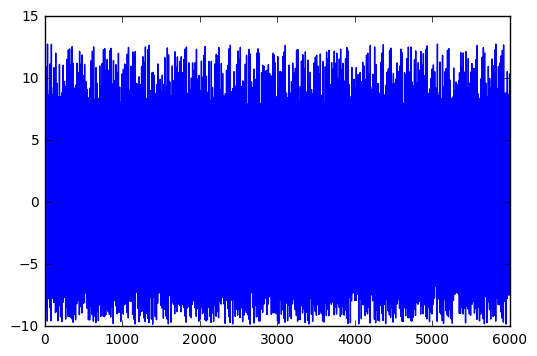

[ -6.73347761  -3.90462627   4.56302452   9.71420955   1.06087243
  -3.62892248  -7.29991969  -2.20871129   6.18533181   7.70494462
  -0.62295128  -5.24193364  -5.93526949   0.20221624   7.70180776
   5.50598829  -0.60231973  -6.54543248  -6.40104324   1.11727631
   9.90604372   4.06298472  -0.92659747  -3.00587985   1.25328026
   4.8602249    4.80399645   1.14688941  -3.26389915  -6.08435669
  -2.76453788   5.63523662   9.53977847   1.12212297  -3.77264403
  -7.37600073  -1.95570328   6.8329777    7.78645627  -0.86614539
  -4.7611002   -3.60311706   2.04167386   7.09786546   4.17828191
  -0.99437058  -7.30890871  -8.25139899   0.11225197  10.95308147]
1 [  3.25686631e+00  -4.16141767e+00  -9.19053724e+00  -6.04069077e+00
   4.30484895e+00   1.22933139e+01  -2.07276230e+00  -4.75858857e-01
   2.24530192e+00   3.37969508e+00   1.31542673e+00  -2.65777971e+00
  -4.95759205e+00  -2.72493672e+00   2.98179519e+00   7.11374701e+00
   4.51029440e+00  -3.05956052e+00  -9.19379160e+00  -7.45646

64 [  3.29891829e+00   1.10694052e+01  -5.30713629e-01  -2.89863774e+00
  -1.98965621e+00   1.25589832e+00   4.09391292e+00   3.43105003e+00
  -9.43226440e-01  -5.51191595e+00  -5.60685147e+00   1.28310929e-01
   7.31672810e+00   7.71573167e+00  -1.11794305e+00  -7.38775327e+00
  -7.65016877e+00   3.64655630e-03   9.74965232e+00   2.87375796e+00
  -2.33000829e+00  -1.46608393e+00   1.17845453e+00   3.33193816e+00
   2.60696328e+00  -1.00375676e+00  -4.55088585e+00  -4.33917159e+00
   4.65591805e-01   6.11715056e+00   6.65361387e+00   2.16134063e-01
  -7.40730379e+00  -9.41080359e+00  -2.15126815e+00   9.36994965e+00
   2.74420090e+00  -1.15632558e+00   2.27339601e+00   4.28340554e+00
   2.37702435e+00  -2.47454057e+00  -6.07827589e+00  -4.34752744e+00
   2.41157836e+00   8.47060666e+00   5.25364912e+00  -3.16087156e+00
  -8.47411331e+00  -6.43109006e+00]
[ -6.73347761  -3.90462627   4.56302452   9.71420955   1.06087243
  -3.62892248  -7.29991969  -2.20871129   6.18533181   7.70494462
 

136 [ -4.3097493   -4.44102001   0.03069348   5.71469352   6.78239505
   0.83410854  -6.87731479  -9.53320546  -2.98254945   8.51003962
   5.68093014  -1.44816046   1.81239498   4.0949992    2.73087062
  -1.80514365  -5.69777853  -4.73366515   1.44675528   7.8075082
   6.46283174  -1.98634457  -8.31832925  -7.73165748   1.09577451
  11.13520836  -0.82359548  -1.40434048   1.02194972   3.0619348
   2.47604058  -0.82522508  -4.16438062  -4.08897357   0.28005703
   5.57176562   6.33599293   0.61345963  -6.83953757  -9.2227995
  -2.64655376   8.52615118   5.93740087  -1.66958579   0.98941952
   3.36815315   2.89038911  -0.70036679  -4.53365513  -4.70603225]
[ -6.73347761  -3.90462627   4.56302452   9.71420955   1.06087243
  -3.62892248  -7.29991969  -2.20871129   6.18533181   7.70494462
  -0.62295128  -5.24193364  -5.93526949   0.20221624   7.70180776
   5.50598829  -0.60231973  -6.54543248  -6.40104324   1.11727631
   9.90604372   4.06298472  -0.92659747  -3.00587985   1.25328026
   4.860

In [96]:
print(testing_gene_net_derivative_file("Dataset1/",csv_files[4])) 

In [89]:
print(testing_gene_net_derivative_file("Dataset1/",csv_files[3]))

network_edge_list_EcoCyc.csv


NameError: name 'train_len' is not defined

In [ ]:
M|

In [69]:
 -3.97617392 -3.96445392 -3.95273392
 -3.94101391 -3.92929391])

SyntaxError: invalid syntax (<ipython-input-69-d5b688b4ba7d>, line 1)

In [ ]:
##################################################################################

In [ ]:
rand.uniform(-1,0)

In [ ]:
# NARMA TASK

In [10]:
u_narma= [rand.uniform(0,0.5) for el in range(10501)]
NARMA_result= NARMA_task(10,u_narma,initLen,len(data))
NARMA_result[2000:4000]


array([ 0.3805341 ,  0.26553671,  0.35492398, ...,  0.22025762,
        0.21846962,  0.21918242])

In [ ]:
print("NARMA")
testing_gene_net("Dataset1/",NARMA_result)

In [72]:
calc_MI(np.array([55,56,57,59,60]),np.array([2,4,6,8,10]))


0.0

In [ ]:
###################################

In [97]:
print("With derivatives")
MI_by_file, X_by_file, Y_by_file=testing_gene_net_derivative("Dataset1/", a,b,c)

With derivatives
network_edge_list_ENCODE.csv
207 NRMSE = 2.50755931313664
[  6.76656966   1.57829895  -5.95547357  -9.35981606  -3.95233785
   7.41152562   8.86255159  -1.81764628   0.38573717   2.71823334
   3.1950572    0.41234583  -3.64697366  -4.85933727  -1.35989076
   4.18786701   7.33543821   2.74720577  -5.23155562  -9.6672628
  -5.48903949   5.77753766  11.40048504  -1.66445506   0.78073618
   3.73236397   3.33358287  -0.52025717  -5.02620677  -5.51782926
  -0.38845506   6.4265001    7.7504683   -0.10418288  -7.15339104
  -8.85539409  -1.6896933    9.00152539   4.55123771  -1.83164715
   0.5616765    2.93688034   2.88808318  -0.05328955  -3.77886704
  -4.50287891  -0.70400819   4.53787662   7.06455748   2.21842573]
1 [  0.31972696  -3.51313599  -4.74637255  -1.36771034   4.38584264
   7.0546255    2.74069228  -5.01177099  -9.57884258  -5.43143673
   5.55449405  12.02767788  -2.05040556   0.60557016   3.43458916
   3.45695329  -0.08817711  -4.4891074   -5.43371028  -0.96806207

486 NRMSE = 2.5332983352145275
[  0.5929182   -6.23333069  -7.91158485  -1.84050818   7.77050672
   7.69080996  -2.4839072   -2.90266747  -0.67724804   2.84072435
   4.51155411   1.8909149   -3.38181556  -6.39651463  -3.66613055
   3.81009902   9.40724437   3.22045541  -4.42223076  -8.25055138
  -4.4876005    5.0283891   11.13895405  -1.00404452  -2.99468247
  -1.68503385   1.84792683   4.17767273   2.93146261  -1.81328726
  -5.96352534  -5.09473172   1.48440307   8.20735349   6.06271802
  -2.36320108  -7.87945835  -6.78450581   1.82866259  11.04480345
   1.10895366  -2.57918871  -1.68297351   1.2806554    3.60253151
   2.94376291  -0.99085915  -5.08374544  -4.8205233    0.59670395]
1 [ -5.56828389  -9.4852426   -4.60187323   6.45805404  10.99018076
  -1.96518244   0.52960745   3.20729685   3.27715528  -0.02315212
  -4.18335117  -5.13819473  -0.99404827   5.34596838   7.63425102
   1.83141454  -6.16413281  -9.81226624  -4.24282099   7.31827145
   9.17889954  -1.64028294   1.81961721   

23 [ -4.21544696  -3.61446262   0.93239905   5.76570143   5.74648765
  -0.23288336  -7.28847656  -8.70989385  -1.43567631   9.351171
   3.51194913  -1.73866976   0.48647903   2.83356842   2.87635153
  -0.04457272  -3.70503011  -4.5185017   -0.83983876   4.74461498
   6.8073814    2.08654644  -5.56828389  -9.4852426   -4.60187323
   6.45805404  10.99018076  -1.96518244   0.52960745   3.20729685
   3.27715528  -0.02315212  -4.18335117  -5.13819473  -0.99404827
   5.34596838   7.63425102   1.83141454  -6.16413281  -9.81226624
  -4.24282099   7.31827145   9.17889954  -1.64028294   1.81961721
   4.35724548   3.03680971  -1.7534299   -6.01818674  -5.19674055]
[  0.5929182   -6.23333069  -7.91158485  -1.84050818   7.77050672
   7.69080996  -2.4839072   -2.90266747  -0.67724804   2.84072435
   4.51155411   1.8909149   -3.38181556  -6.39651463  -3.66613055
   3.81009902   9.40724437   3.22045541  -4.42223076  -8.25055138
  -4.4876005    5.0283891   11.13895405  -1.00404452  -2.99468247
  -1.685

289 NRMSE = 2.5358448762632615
[ -5.86445549  -5.57834297   0.62907927   7.66813858   6.76481379
  -1.79576421  -7.55787428  -6.94741386   1.0683577   10.3516447
   2.35648749  -2.6776334   -2.39110387   0.5245483    3.6286136
   3.97553713   0.17659923  -4.67693388  -6.00203007  -1.31096226
   6.02445151   8.54981096   0.60267287  -6.51845457  -8.52747147
  -2.36729091   7.92319842   7.15052781  -2.42308221  -1.07036218
   1.23502711   3.00125852   2.15175288  -1.2212312   -4.41355885
  -3.87139554   0.86927642   5.57411996   6.07298639  -0.06645871
  -7.47158039  -8.82086325  -1.62960207   9.28646954   3.88016907
  -1.66743471   0.9804304    3.20706113   2.75228237  -0.69887509]
1 [  7.45466485  -1.93963877  -6.91799265  -6.04008596   1.39409532
   9.38532672   4.22577781  -3.18005373  -5.17250398  -2.31827107
   3.75869675   7.51440993   3.81595572  -4.11382865  -9.620781
  -6.63446765   4.1220826   12.74517234  -2.20870882   0.75655229
   3.8927166    3.81936841  -0.21776523  -5.10

70 NRMSE = 2.5029066430767988
[  6.75370197   0.2247487   -7.16322659  -9.14297681  -2.18674853
   9.14389988   4.37984559  -1.28313256   2.14227317   4.19341284
   2.43478111  -2.2772392   -5.94550179  -4.347399     2.03913882
   8.62000977   5.28122178  -3.0196948   -8.64489794  -7.02937165
   2.21776562  11.83396677  -0.85649475  -1.42874292   0.75637632
   2.77757114   2.62116092  -0.32800754  -3.88183937  -4.32865741
  -0.40623115   4.69342664   6.69416878   1.68312711  -5.64808252
  -9.0382607   -3.56516407   7.06426798   8.99371567  -1.410406
  -0.16182511   2.35363214   3.23842785   0.81112256  -3.09197802
  -4.98347128  -1.94063002   3.5237195    7.37903227   3.57348206]
1 [ -0.63328566  -8.05935274  -9.13669286  -0.97563253  10.44595131
  -0.18945205  -0.71631492   2.85473204   4.42994998   1.82242614
  -3.3387367   -6.44432695  -3.69358946   3.6882446    9.12220733
   3.26235341  -4.4133544   -8.22221294  -4.5174529    4.94646408
  11.20031298  -1.3939149   -2.97532583  -1.6

13 NRMSE = 2.498070154452361
[  6.89859067   6.50154758  -0.92255861  -5.06676093  -9.33411909
  -1.078149     8.6611067    5.82707081  -2.05035924   0.1933536
   3.20364219   3.31039614  -0.31801449  -3.63619809  -4.63283051
  -0.58457981   5.40552639   7.28084875   0.6056039   -3.4811571
  -9.74699068  -4.28584104   5.85729264  10.53682238  -1.76735391
   0.58824518   3.03345415   3.16103122  -0.8743751   -4.43010114
  -5.55899596  -0.93337195   5.63957319   7.56210595   0.03874921
  -3.65171852 -10.25743699  -4.02371304   6.7740574   10.06796193
  -1.84038964   1.99944853   4.0310451    1.40563073  -3.09613834
  -6.85163737  -5.72581394   1.03379811   8.41237727   4.14405519]
1 [ -2.71096639  -6.03996513  -3.99718226   2.79554533   8.48318725
   4.87519235  -3.43718563  -8.75516793  -6.42681574   3.26985111
  11.89719635  -1.70990739  -1.36982486   0.96370455   2.94558569
   2.40777786  -0.7626356   -4.00047409  -3.96607796   0.2221673
   5.34430254   6.16451986   0.72292286  -6.585

In [98]:
MI_by_file

{'DBTBS': {1: 0.17006544128932888,
  2: 0.099000821307994105,
  3: 0.079871180841006154,
  4: 0.1316539538823267,
  5: 0.13307642266277381,
  6: 0.090016081809242615,
  7: 0.095931984067686549,
  8: 0.11523541758092459,
  9: 0.13812734587302777,
  10: 0.36426692449531495,
  11: 0.16046592816375471,
  12: 0.078245569964443651,
  13: 0.63456281968566441,
  14: 0.21474547390551055,
  15: 0.11013188016344773,
  16: 0.41117517535839648,
  17: 0.16151851249849736,
  18: 0.052021112574990591,
  19: 0.082873959865729041,
  20: 0.098092210268109936,
  21: 0.11153802912953209,
  22: 0.095833691052694125,
  23: 0.1267358477532424,
  24: 0.11523541758092459,
  25: 0.15290031093792258,
  26: 0.39736518138110144,
  27: 0.16150857605229377,
  28: 0.077943912901679874,
  29: 0.62370085995761138,
  30: 0.22152394999112454,
  31: 0.10699498364890331,
  32: 0.39325467996607655,
  33: 0.1654976393628233,
  34: 0.079377115351683805,
  35: 0.093907220336720748,
  36: 0.089018811607747189,
  37: 0.1045729561

In [ ]:
ee.vectorize([1,2,3])

In [ ]:
from math import log,pi
list(map(log,[1,2,3]))